## Import Necessary Packages

In [1]:
from z3 import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy.ndimage import label
from IPython.display import Markdown, display

## Define Grid Regions

In [2]:
regions = np.array([[  1,  1,  6,  6, 14, 14, 14, 14, 14, 14, 19, 19, 19, 19, 19, 19, 19],
                    [  1,  1,  1,  6,  6,  6,  6, 14, 14, 14, 19, 18, 18, 18, 18, 19, 19],
                    [  1,  2,  2,  2,  6,  6,  6, 14,  5, 14, 19, 18, 19, 19, 18, 20, 19],
                    [  1,  2,  2,  6,  6,  6,  6,  5,  5, 14, 19, 19, 19, 18, 18, 20, 19],
                    [  1,  2,  3,  6,  5,  5,  5,  5, 13, 16, 16, 19, 19, 18, 20, 20, 19],
                    [  1,  2,  3,  3,  5,  3, 13, 13, 13,  4, 16, 19, 19, 18, 18, 20, 20],
                    [  1,  2, 12,  3,  3,  3, 13, 13, 13,  4, 16, 19, 19, 17, 18, 20, 20],
                    [  1,  2, 12, 12,  3, 13, 13,  4,  4,  4, 16, 19, 16, 17, 20, 20, 20],
                    [  1,  2, 12, 12, 12, 13, 13,  4, 16, 16, 16, 16, 16, 17, 17, 20, 20],
                    [  1,  2, 12, 12, 12, 12,  4,  4, 10, 10, 16, 17, 16, 17, 20, 20, 20],
                    [  1,  2, 12, 12, 12,  4,  4, 15, 15, 10, 10, 17, 17, 17, 17, 17, 20],
                    [  1,  2, 12, 12,  4,  4, 15, 15, 15, 11, 10, 10,  9,  9, 20, 17, 20],
                    [  1,  2, 12, 15, 15, 15, 15, 15, 11, 11, 11, 10, 10,  9, 20, 20, 20],
                    [  1,  2, 15, 15, 15, 15, 15, 15, 11,  8, 11,  9,  9,  9,  9, 20, 20],
                    [  1,  2,  2, 15,  1,  1,  7, 11, 11,  8,  9,  9,  8,  8,  9,  9, 20],
                    [  1,  1,  2,  2,  1,  7,  7,  8,  8,  8,  8,  8,  8,  8, 20, 20, 20],
                    [  1,  1,  1,  1,  1,  1,  7,  7,  7,  7,  7,  7,  7,  8, 20, 20, 20]], dtype=int)

## Column and Row Sums

In [3]:
rows = np.array([14,24,24,39,43,-1,22,23,29,28,34,36,29,26,26,24,20], dtype=int)
cols = np.array([13,20,22,28,30,36,35,39,49,39,39,-1,23,32,23,17,13], dtype=int)

## Define All F-Pentominos

In [4]:
one = np.array([[0, 1, 1],
                [1, 1, 0],
                [0, 1, 0]], dtype=int)

two = np.kron(one, np.ones((2, 2), dtype=int))
three = np.kron(one, np.ones((3, 3), dtype=int))

all_rotations_and_flips = lambda x: (rotations := [np.rot90(x, k) for k in range(4)]) + [np.fliplr(r) for r in rotations]
shape_matricies = [all_rotations_and_flips(size) for size in [one, two, three]]

## Solution Output

In [5]:
def grid_print(groups,numbers):
    _, ax = plt.subplots(1,1,figsize=(9,9))
    x = np.array((numbers).astype('int').astype('str'))
    x[x=="0"] = "-"
    ax = sns.heatmap(groups,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=1,alpha=.8)
    ax.set_xticklabels(cols, rotation=0)
    ax.set_yticklabels(rows, rotation=0)
    plt.tight_layout()
    plt.show()
    
def areas(grid):
    labels, num = label(np.logical_not(grid!=0))
    areas = [np.sum(labels == i) for i in range(1, num + 1)]
    return np.prod(areas)

## Logic Helper Lambda Expressions

In [6]:
can_place_grid = lambda i,j,c,N: i+len(shape_matricies[c-1][0])-1<N and j+len(shape_matricies[c-1][0][0])-1<N

point_included = lambda i,j,si,sj,shape: (i,j) in [(si+a,sj+b) for (a,b),v in np.ndenumerate(shape) if v!=0]

top_lefts = lambda i,j,c,shape,N: [(x,y) for (x,y) in product(range(N), repeat=2) if can_place_grid(x,y,c,N) and point_included(i,j,x,y,shape)]

fit_shape = lambda i,j,c,shape,N,X: Or([And([X[a+x][b+y]==c for (x,y),v in np.ndenumerate(shape) if v!=0]) for (a,b) in top_lefts(i,j,c,shape,N)])

fit_f = lambda i,j,c,N,X: Or([fit_shape(i,j,c,shape,N,X) for shape in shape_matricies[c-1]])

## Add Constraints and Solve

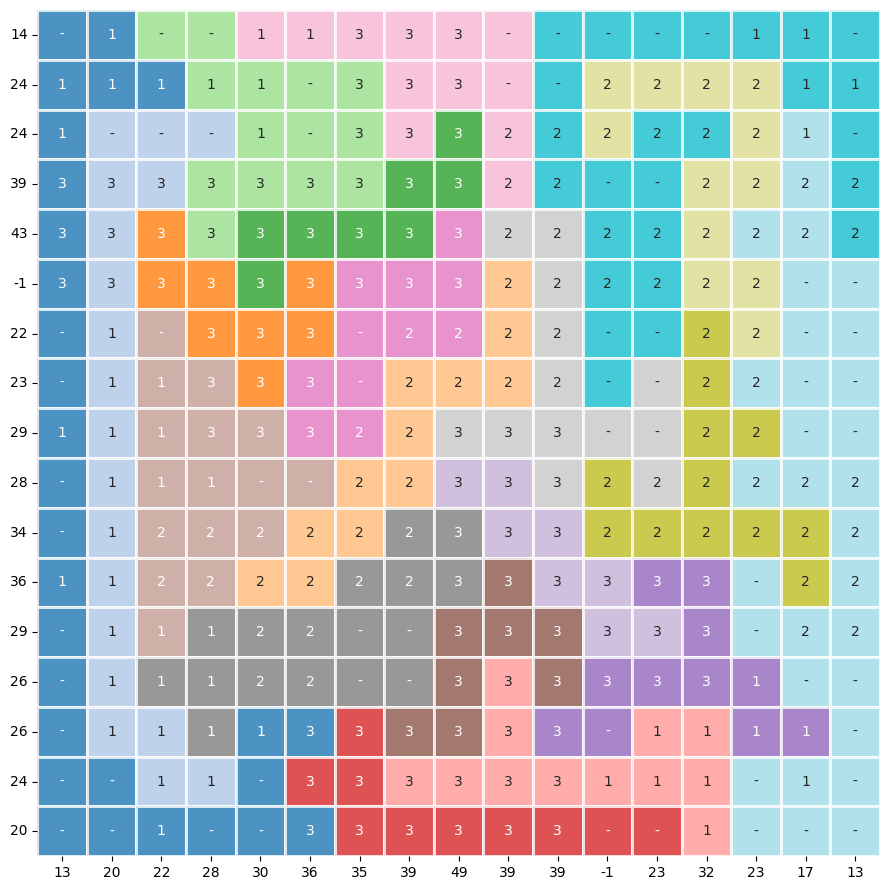

### Answer is: 346,816,512

In [7]:
N = len(rows)
s = Solver()
X = np.array(IntVector("x", N**2), dtype=object).reshape((N,N))

s += [And(np.sum(X[i,:]) == r) for i,r in enumerate(rows) if r != -1]
s += [And(np.sum(X[:,j]) == c) for j,c in enumerate(cols) if c != -1]

s += [And(0<=n, n<=3) for n in X.ravel()]
s += [Implies(X[i][j]==c, fit_f(i,j,c,N,X)) for (i,j) in product(range(N), repeat=2) for c in range(1,4)]
s += [np.sum(X[regions==i])==np.sum(X[regions==1]) for i in range(2, np.max(regions)+1)]

if s.check() == sat:
    m = s.model()
    eval = np.vectorize(lambda x: m.evaluate(x).as_long())
    grid = eval(X)
    grid_print(regions, grid)
    display(Markdown('### Answer is: {:,.0f}'.format((areas(grid)))))